In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../scripts')
import util

# from Yesh's DIF_IP script
from pixval import Formatter
import blob_utils as bu
from enum import IntEnum
from skimage import measure

green = (0, 255, 0)

### Set all the params from Yesh's script

In [2]:

DIF_ImageProcParams = {}
# Imaging settings
DIF_ImageProcParams['timeLapse_us'] = 4    # Time lapse between images for velocity calc
DIF_ImageProcParams['pxSize_um'] = 0.345 ;#0.350
# Image crop bounds and sub-sample step size
DIF_ImageProcParams['frameHeight_px'] = 2160 ;#1040
DIF_ImageProcParams['frameWidth_px'] = 2560 ;#1392
DIF_ImageProcParams['rMin'] = 1028 ;#528 ;#648
DIF_ImageProcParams['rMax'] = 2160 ;#2148
DIF_ImageProcParams['cMin'] = 0
DIF_ImageProcParams['cMax'] = 2560 ;#2548
DIF_ImageProcParams['rStep'] = 1
DIF_ImageProcParams['cStep'] = 1

# Preprocessing params
DIF_ImageProcParams['bg_thresh'] = 30
DIF_ImageProcParams['blurKernelSize'] = int(15/DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['tophatKernalSize'] = int(43/DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['adaptiveMethod'] = cv2.ADAPTIVE_THRESH_GAUSSIAN_C #cv2.ADAPTIVE_THRESH_MEAN_C #cv2.ADAPTIVE_THRESH_GAUSSIAN_C
DIF_ImageProcParams['thresholdType'] = cv2.THRESH_BINARY+cv2.THRESH_OTSU#cv2.THRESH_BINARY #cv2.THRESH_BINARY_INV
DIF_ImageProcParams['blockSize'] = 25 #odd number like 3,5,7,9,11
DIF_ImageProcParams['subConst'] = 2 # constant to be subtracted
DIF_ImageProcParams['minThVal'] = 0      # Min and max threshold values
DIF_ImageProcParams['maxThVal'] = 255

# Params for pruning blobs by size, circularity
DIF_ImageProcParams['circTh'] = 0.7
DIF_ImageProcParams['minSzInPx'] = 400/(DIF_ImageProcParams['rStep']*DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['maxSzInPx'] = 1600/(DIF_ImageProcParams['rStep']*DIF_ImageProcParams['rStep'])
# Used to filter out images with no drop (hence too many stray objects) and too many drops
DIF_ImageProcParams['maxDropsPerImg'] = 200

# Line registration params
DIF_ImageProcParams['intraLineSpecPx'] = int(30/DIF_ImageProcParams['cStep'])
DIF_ImageProcParams['maxDiffInMeanForSameLines_px'] = int(20/DIF_ImageProcParams['cStep'])
DIF_ImageProcParams['maxInterDrpToDrpDist_px'] = int(70/DIF_ImageProcParams['rStep'])    # Should be set based on min possible velocity
DIF_ImageProcParams['maxDrpToDrpDistInTime_px'] = int(20/DIF_ImageProcParams['rStep'])

# Dispenser and nozzle settings
DIF_ImageProcParams['nozzSpacing_um'] = 141.1082
DIF_ImageProcParams['phaseIDs'] = [1,2,3]

# Blob registration parameters
DIF_ImageProcParams['blobCorrBBXSzPx'] = 101       ;# Correlation bounding box X size (width)
DIF_ImageProcParams['blobCorrBBYSzPx'] = 101       ;# Correlation bounding box Y size (height)
DIF_ImageProcParams['blobCorrTh'] = 0.95           ;# Blob correlation threshold
DIF_ImageProcParams['xDispPxTh'] = 10              ;# Max X displacement in pixels
DIF_ImageProcParams['yDispPxTh'] = 150             ;# Max Y displacement in pixels
DIF_ImageProcParams['areaDiffTh'] = 100            ;# Max diff in areas of corresponding blobs
DIF_ImageProcParams['majorAxisDiffTh'] = 10        ;# Max diff in major axis lengths of corres blobs
DIF_ImageProcParams['minorAxisDiffTh'] = 10        ;# Max diff in minor axis lengths of corres blobs


rMin = DIF_ImageProcParams['rMin']
rMax = DIF_ImageProcParams['rMax']
cMin = DIF_ImageProcParams['cMin']
cMax = DIF_ImageProcParams['cMax']
rStep =DIF_ImageProcParams['rStep']
cStep =DIF_ImageProcParams['cStep']
frameHeight_px = DIF_ImageProcParams['frameHeight_px']

rStep     = DIF_ImageProcParams['rStep']
cStep     = DIF_ImageProcParams['cStep']
circTh    = DIF_ImageProcParams['circTh']
minSzInPx = DIF_ImageProcParams['minSzInPx']
maxSzInPx = DIF_ImageProcParams['maxSzInPx']
maxDropsPerImg = DIF_ImageProcParams['maxDropsPerImg']
timeLapse_us   = DIF_ImageProcParams['timeLapse_us']
pxSize_um      = DIF_ImageProcParams['pxSize_um']



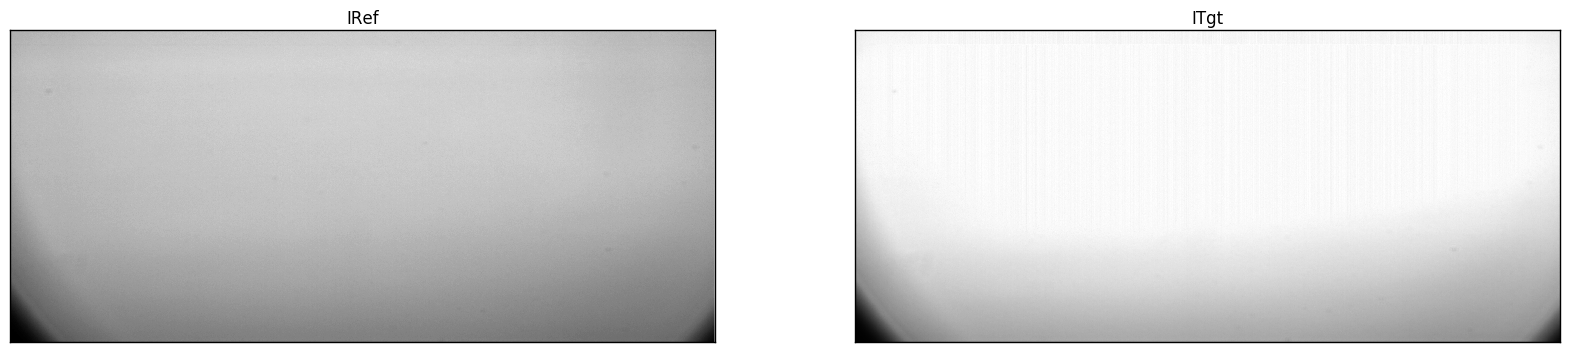

In [8]:
image_path = '../images/dif/images_bad_laser/2017-03-28_16.19.40_DIF_Capture.tif'
#image_path = '../images/dif/images_bad_laser/DispenserOpt_00062_2016-10-31_14.02.02.png'

im16 = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# First make 2D by slicing out one channel
if len(im16.shape) == 3:
    im16 = im16[:,:,1]

# if 16bit, convert to 8bit
if im16.dtype.name.find('16') >= 0:
    #im8 = bu.convert16BitTo8Bit(im16)
    im8 = im16
else:
    im8 = im16

# now subimage into ref and tgt
if (im8.shape[0] == 2*frameHeight_px):
    ITgt = im8[frameHeight_px+rMin:frameHeight_px+rMax:rStep,cMin:cMax:cStep]

IRef = im8[rMin:rMax:rStep,cMin:cMax:cStep]

util.plot_imgs([(IRef, 'IRef'), (ITgt, 'ITgt')], max_cols = 2)
# img_data_lst=[(IRef, 'IRef'), (ITgt, 'ITgt')]
# max_cols = 2
# color=False
# interp='none'
# fig_size=10
# cnt=len(img_data_lst)
# r,c,n = cnt,cnt,1
# for idx, img_data in enumerate(img_data_lst):
#     if idx % max_cols == 0:
#         plt.figure(figsize=(fig_size*r,fig_size*c))
#     plt.subplot(r,c,idx+1)
#     if color:
#         #plt.imshow(img_data[0], interpolation='none', vmax=abs(img_data[0]).max(), vmin=-abs(img_data[0]).max())
#         plt.imshow(img_data[0].astype(np.float), interpolation=interp)
#     else:
#         plt.imshow(img_data[0].astype(np.float), interpolation=interp, cmap='gray',)
#     plt.title('%s' % (img_data[1])), plt.xticks([]), plt.yticks([])


In [9]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape).astype(np.uint16)

uint16
uint8


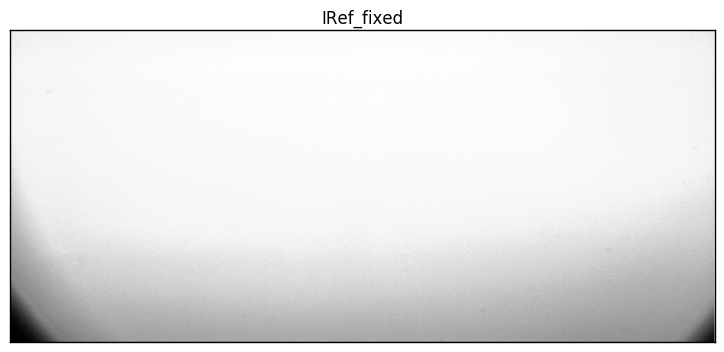

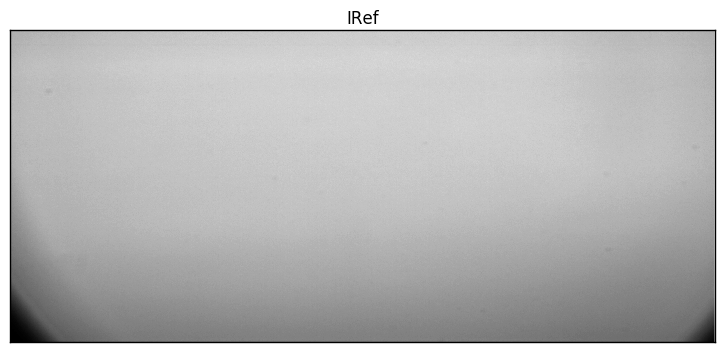

In [11]:
IRef_fixed = hist_match(IRef, ITgt)

print(IRef_fixed.dtype)
print(ITgt.dtype)

im_combined = IRef_fixed + ITgt
#im_combined = cv2.bitwise_and(IRef_fixed, ITgt)

#util.plot_imgs([(IRef_fixed, 'IRef'), (ITgt, 'ITgt'), (im_combined, 'im_combined')], max_cols = 1)
util.plot_imgs([(IRef_fixed, 'IRef_fixed'), (IRef, 'IRef')], max_cols = 1)